## Final Model

In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import random

# Preprocessing and scaling
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Feature selection
from sklearn.feature_selection import RFE

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.exceptions import ConvergenceWarning

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

# Statistical functions
import scipy.stats as stats

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# General settings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("training_data_fall2024.csv")

In [4]:
data['increase_stock'] = data['increase_stock'].apply(lambda x: 1 if x == 'high_bike_demand' else 0)

In [5]:
data['heat_index'] = data['temp'] * data['humidity']

In [6]:
data['temp_humidity_ratio'] = data['temp'] / (data['humidity'] + 1e-5)  # Avoid division by zero

In [7]:
train, test = train_test_split(data, test_size=0.2, random_state=42)
y_train = train['increase_stock']
y_test = test['increase_stock']
X_train = train.drop(columns=['increase_stock'])
X_test = test.drop(columns=['increase_stock'])

In [8]:
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (1280, 17)
X_test Shape: (320, 17)
y_train Shape: (1280,)
y_test Shape: (320,)


## Model Training

In [10]:
 # Final Model 

# Selected features
features = ['hour_of_day', 'temp', 'windspeed', 'heat_index', 'temp_humidity_ratio']

# Subset the training and testing data to include only the selected features
X_train_new = X_train[features]
X_test_new = X_test[features]

# Define the model with the specified parameters for RandomForestClassifier
model = AdaBoostClassifier(
    algorithm = 'SAMME',
    learning_rate = 1.0,
    n_estimators = 200,
    random_state=42
)

# Pipeline with scaler and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler step
    ('model', model)  # Decision Tree Classifier model with predefined parameters
])

# Fit the pipeline
pipeline.fit(X_train_new, y_train)

# Predictions
predictions = pipeline.predict(X_test_new)
probabilities = pipeline.predict_proba(X_test_new)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary')
roc_auc = roc_auc_score(y_test, probabilities)

# Results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=["low demand", "high demand"]))

Accuracy: 0.853
Precision: 0.527
Recall: 0.580
F1-Score: 0.552
ROC-AUC: 0.890

Classification Report:
              precision    recall  f1-score   support

  low demand       0.92      0.90      0.91       270
 high demand       0.53      0.58      0.55        50

    accuracy                           0.85       320
   macro avg       0.72      0.74      0.73       320
weighted avg       0.86      0.85      0.86       320



In [11]:
test = pd.read_csv("test_data_fall2024.csv")
test['heat_index'] = test['temp'] * test['humidity']
test['temp_humidity_ratio'] = test['temp'] / (test['humidity'] + 1e-5)  # Avoid division by zero

In [12]:
# Ensure the test data contains only the selected features
features = ['hour_of_day', 'temp', 'windspeed', 'heat_index', 'temp_humidity_ratio']
X_test_new = test[features]

# Make predictions
predictions = pipeline.predict(X_test_new)
probabilities = pipeline.predict_proba(X_test_new)[:, 1]

# Map predictions to categorical labels
mapped_predictions = ['high_bike_demand' if pred == 1 else 'low_bike_demand' for pred in predictions]

# Add the predictions and probabilities to a new dataset
results = pd.DataFrame({
    'predicted_class': mapped_predictions,
    'predicted_probability': probabilities
})

results.to_csv("results_fall2024.csv", index=False)

output_file = "predictions.csv"
with open(output_file, "w") as f:
    f.write(",".join(map(str, predictions)))

print(f"Predictions saved to {output_file}")

Predictions saved to predictions.csv


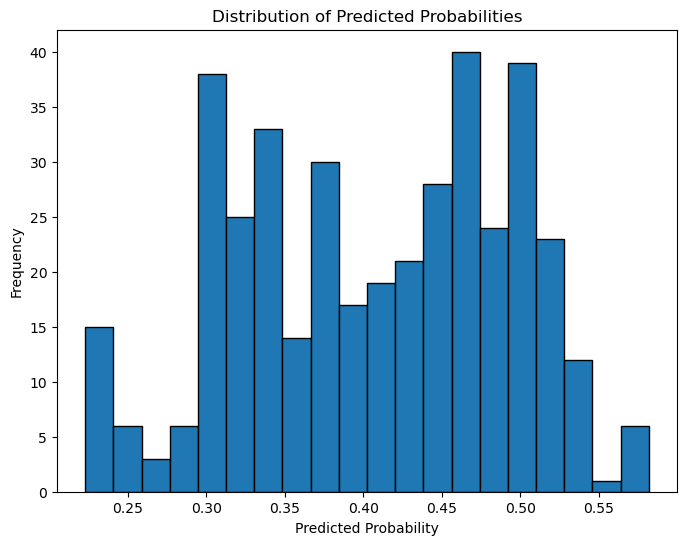

In [13]:
# Plot distribution of predicted probabilities (how confident the model is in its predictions)
plt.figure(figsize=(8, 6))
plt.hist(probabilities, bins=20, edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

#The probabilities are concentrated between 0.25 and 0.55. There are no extreme probabilities close to 0 or 1, 
#suggesting the model may lack high confidence predictions.
#The distribution appears bimodal, with peaks around 0.3 and 0.45–0.5. This may indicate that the model is uncertain 
#about clear separation between classes.
#High frequency of predictions around 0.3 and 0.45 might reflect overlap in the feature space for both classes.
#Fewer predictions beyond 0.5 could imply difficulty in identifying high_bike_demand confidently.

<Figure size 1200x600 with 0 Axes>

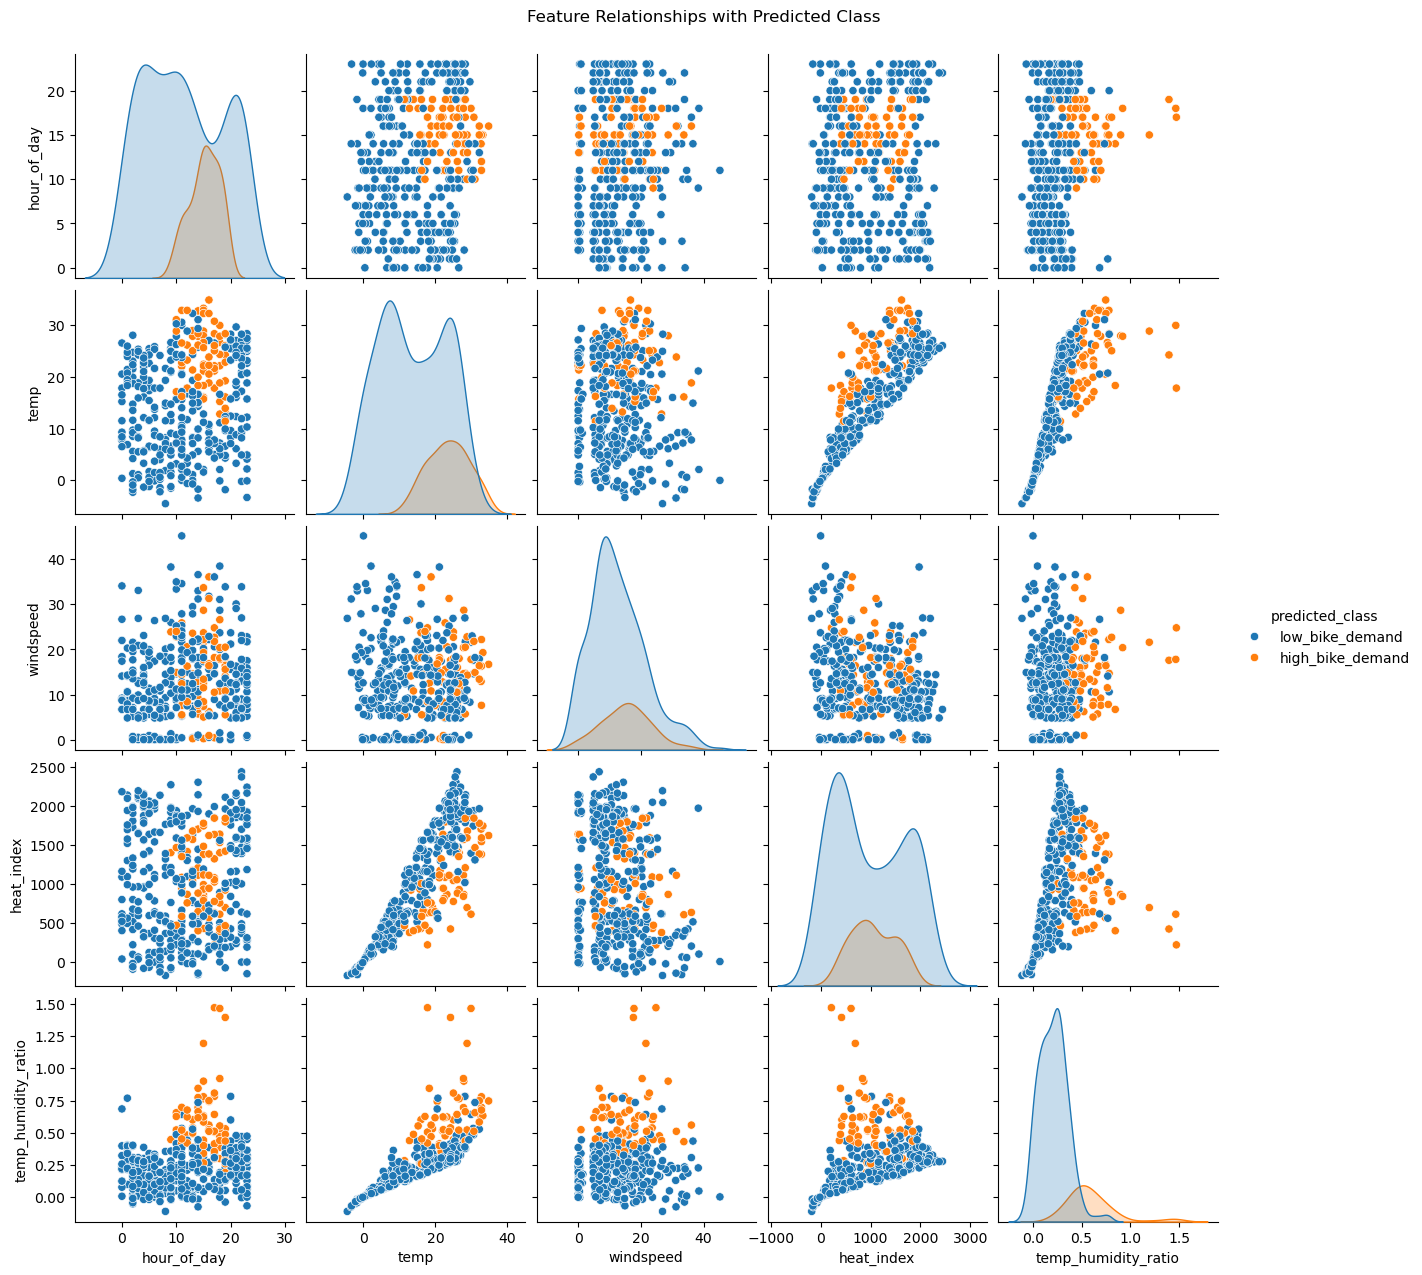

In [14]:
#visualize how features relate to the predicted class
test_data_with_predictions = test.copy()
test_data_with_predictions['predicted_class'] = mapped_predictions
test_data_with_predictions['predicted_probability'] = probabilities

plt.figure(figsize=(12, 6))
sns.pairplot(test_data_with_predictions, hue='predicted_class', vars=features)
plt.suptitle('Feature Relationships with Predicted Class', y=1.02)
plt.show()


Predicted Class Distribution:
predicted_class
low_bike_demand     328
high_bike_demand     72
Name: count, dtype: int64


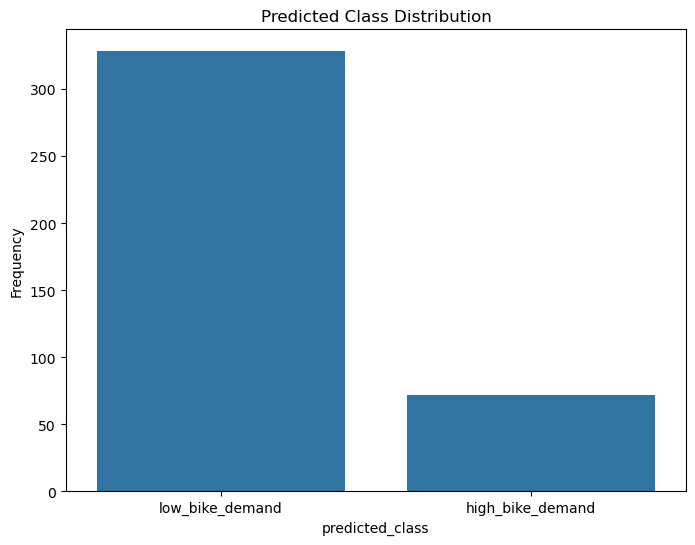

In [15]:
# Check the count of predicted classes
class_counts = test_data_with_predictions['predicted_class'].value_counts()
print(f"Predicted Class Distribution:\n{class_counts}")

# Plot the distribution of predicted classes
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_class', data=test_data_with_predictions)
plt.title('Predicted Class Distribution')
plt.ylabel('Frequency')
plt.show()

#The model heavily favoring one class, but this is consistent with what we expected based on the dataset

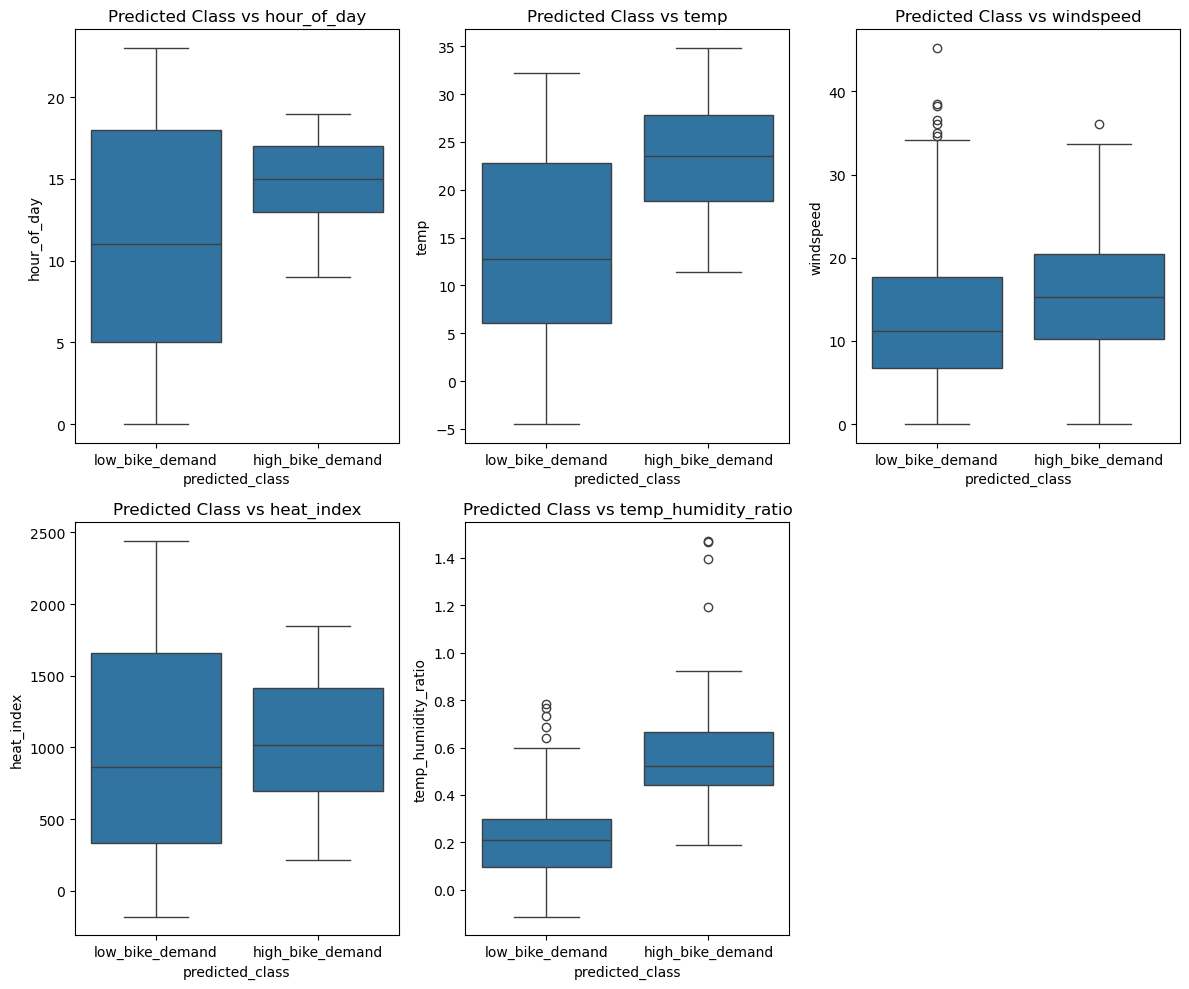

In [16]:
plt.figure(figsize=(12, 10)) 
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)  
    sns.boxplot(x='predicted_class', y=feature, data=test_data_with_predictions)
    plt.title(f'Predicted Class vs {feature}')
    plt.tight_layout() 
plt.show()

In [17]:
merged_results = pd.concat([X_test_new, results['predicted_probability']], axis=1)
correlations = merged_results.corr()['predicted_probability']
print(correlations)

hour_of_day              0.511188
temp                     0.499434
windspeed                0.153673
heat_index               0.192540
temp_humidity_ratio      0.652684
predicted_probability    1.000000
Name: predicted_probability, dtype: float64


<Axes: xlabel='temp_humidity_ratio', ylabel='predicted_probability'>

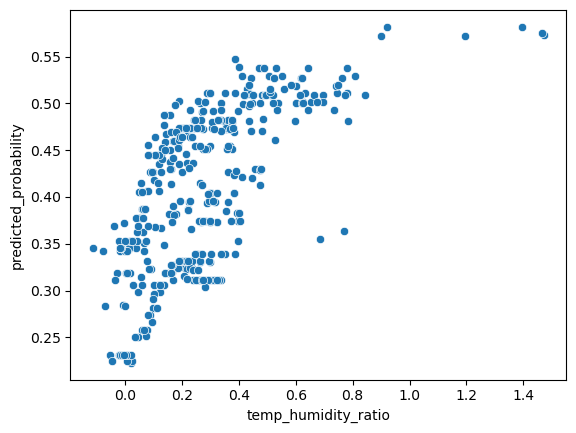

In [18]:
import seaborn as sns
sns.scatterplot(x=X_test_new['temp_humidity_ratio'], y=results['predicted_probability'])


<Axes: title={'center': 'Bike Demand by Hour of Day'}, xlabel='hour_of_day'>

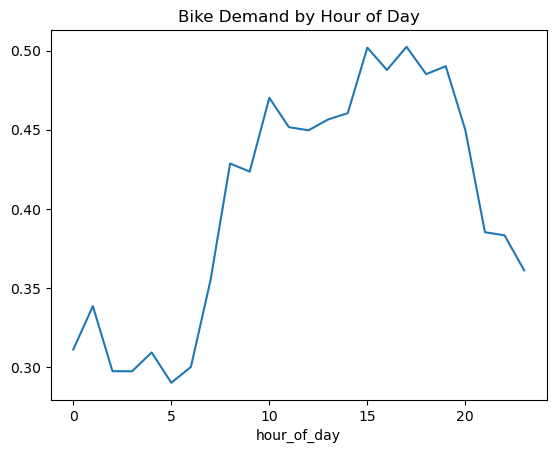

In [19]:
results['hour_of_day'] = X_test_new['hour_of_day']
results.groupby('hour_of_day')['predicted_probability'].mean().plot(kind='line', title='Bike Demand by Hour of Day')
